# Precomputation of exposure integral

Now that we implement the effective area as a function of energy and zenith angle, can keep the fit fast by precomputing the exposure factor for each source. This is possible if assuming *known* source positions and redshifts.

For now, we assume that the background has some fixed redshift. This is necessary in order to compute the energy losses in the simulation. This is something that will probably be changed in the next step as we include selection effects and try to do something more realistic. 

## What is the exposure integral?

As part of the simulation and fit, we want to compute the expected number of detected neutrinos from each source component. This can be written as $\bar{N}_k = F_k \epsilon_k$ where $F_k = \frac{Q}{4 \pi d_l(z_k)^2}$ and the exposure factor is 
$$
\epsilon_k = T \frac{(\alpha-1)}{E_{\rm{min}}} \int_{E_{\rm{min}}}^\infty {\rm{d}}E \ A_{\rm{eff}}(E, \varpi_k) 
\Bigg( \frac{(1+z_k)E}{E_{\rm{min}}} \Bigg)^{-\alpha} = T \frac{(\alpha-1)}{E_{\rm{min}}} I_k, 
$$
where $k$ is the index for each source (see likelihood derivation for details).

Here we will compute $I_k$ for a range of $\alpha$ so that we can perform fast linear interpolation in the fit for unknown $\alpha$.

In [1]:
import numpy as np
import h5py
from scipy.interpolate import RectBivariateSpline

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

### Effective area

Use the module provided by Martin & Hans to produce a spline with scipy (same code, just a few edits to run in python 3). Also, use a quick spline implementation to tets out the case for muon tracks.

In [2]:
from aeff_calculator.aeff_calculator import effective_area_tracks, effective_area_cascades

aeff_tracks = effective_area_tracks()
aeff_cascades = effective_area_cascades("nue_CC")

... creating effective area spline for interaction nue_CC , done!


### Sources

Use a set of sources sampled as having redshift uniform in comoving volume for a $\Lambda CDM$ universe.

In [3]:
with h5py.File('../data/test_SFR_pop.h5', 'r') as f:
    Ns = f['output/Ns'].value
    redshift = f['output/redshift'][()]
    position = f['output/position'][()]
    
# Select sources within redshift zth to mimic catalogue
zth = 1
selection = np.where(redshift < zth)[0]
Ns = len(selection)
redshift = np.array([redshift[_] for _ in selection])
position = np.array([position[_] for _ in selection])

# Add background redshift
source_redshift = list(redshift) 
bg_redshift = zth

/Users/fran/.virtualenvs/bayes/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


### Computation

In [4]:
from exposure_integral import ExposureIntegral

/Users/fran/.virtualenvs/bayes/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


#### Cascades

In [ ]:
# Define minimum energy
Emin = 6.0E4 # GeV

exposure_integral = ExposureIntegral(source_redshift, position, bg_redshift, 
                                     aeff_cascades, Emin,
                                    filename='data/precomputed_integral_cascades_6e4.h5',
                                     n_points=100)

In [ ]:
fig, ax = plt.subplots()
for I_k in exposure_integral.integral_grid[:-1]:
    ax.scatter(exposure_integral.alpha_grid, I_k)
ax.scatter(exposure_integral.alpha_grid, exposure_integral.integral_grid[-1], 
           color='k')

#### Tracks

In [5]:
# Define minimum energy
Emin = 1.0E5 # GeV

exposure_integral = ExposureIntegral(source_redshift, position, bg_redshift, 
                                     aeff_tracks, Emin,
                                    filename='data/precomputed_integral_tracks_1e5.h5',
                                     n_points=100)

/Users/fran/projects/astroparticle/hierarchical_nu/dev/statistical_model/4_tracks_and_cascades/aeff_calculator/aeff_calculator.py:172: RuntimeWarning: invalid value encountered in log10
  return np.log10(self.spline(lE, cos_zenith))
/Users/fran/projects/astroparticle/hierarchical_nu/dev/statistical_model/4_tracks_and_cascades/exposure_integral.py:73: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  args=(position, z, alpha))
/Users/fran/projects/astroparticle/hierarchical_nu/dev/statistical_model/4_tracks_and_cascades/exposure_integral.py:73: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from spl

/Users/fran/.virtualenvs/bayes/lib/python3.7/site-packages/scipy/integrate/quadpack.py:860: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  **opt)
/Users/fran/.virtualenvs/bayes/lib/python3.7/site-packages/scipy/integrate/quadpack.py:860: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  **opt)


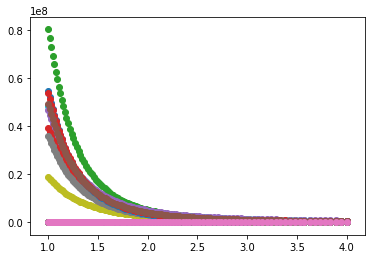

In [6]:
fig, ax = plt.subplots()
for I_k in exposure_integral.integral_grid[:-1]:
    ax.scatter(exposure_integral.alpha_grid, I_k)
ax.scatter(exposure_integral.alpha_grid, exposure_integral.integral_grid[-1], 
           color='k')